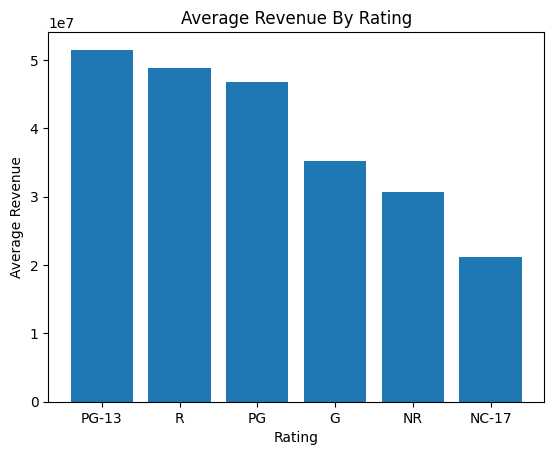

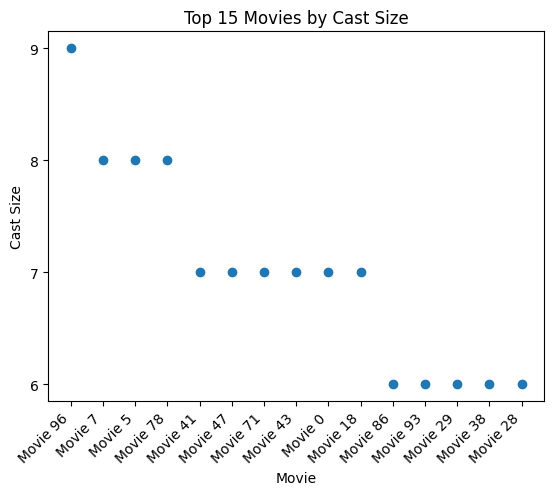

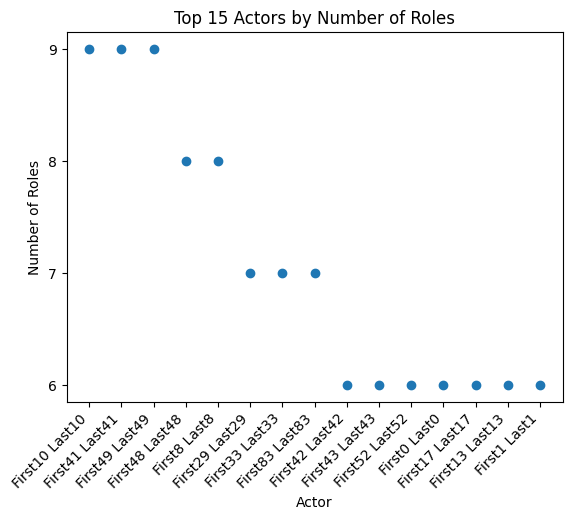

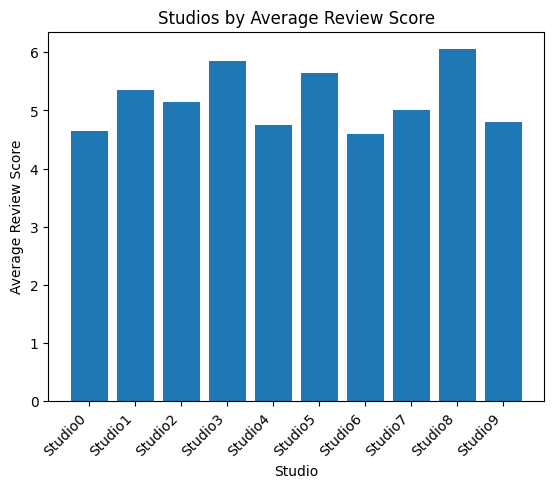

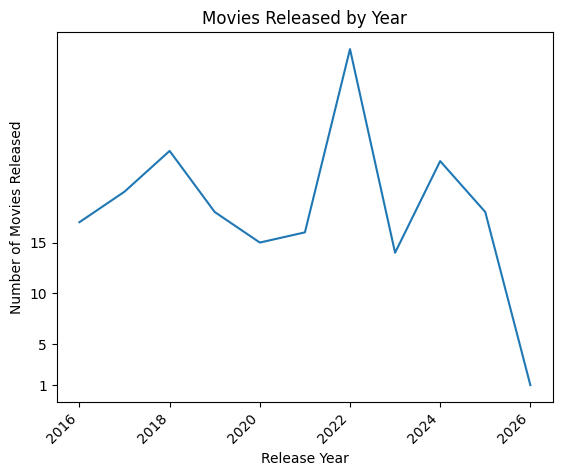

In [14]:
import sys
import os
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)
sys.path.insert(0, project_root)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sqlalchemy import create_engine
from src.domain.actor import Actor
from src.domain.cast import Cast
from src.domain.studio import Studio
from src.domain.review import Review
from src.domain.movie import Movie
from src.services.movie_analytics_service import MovieAnalyticsService

POSTGRES_DB = os.getenv("POSTGRES_DB")
POSTGRES_USER = os.getenv("POSTGRES_USER")
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD")

if not POSTGRES_DB or not POSTGRES_USER or not POSTGRES_PASSWORD:
    raise RuntimeError(
        "Missing env vars: POSTGRES_DB, POSTGRES_USER, POSTGRES_PASSWORD. "
        "Set them in the environment your Jupyter kernel is using."
    )

DB_HOST = os.getenv("POSTGRES_HOST", "localhost")
DB_PORT = os.getenv("POSTGRES_PORT", "5432")

DATABASE_URL = f"postgresql+psycopg://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{DB_HOST}:{DB_PORT}/{POSTGRES_DB}"
engine = create_engine(DATABASE_URL)

movies_df  = pd.read_sql("SELECT * FROM movies;", engine)
studios_df = pd.read_sql("SELECT * FROM studios;", engine)
reviews_df = pd.read_sql("SELECT * FROM reviews;", engine)
actors_df  = pd.read_sql("SELECT * FROM actors;", engine)
casts_df   = pd.read_sql("SELECT * FROM movie_cast;", engine)


movies = [Movie(movie_id=m[0], studio_id=m[1], title=m[2], release_date=m[6], runtime_minutes=m[3], rating=m[4], production_cost=m[7], revenue=m[8], sequel_to_movie_id=m[5]) for m in movies_df.itertuples(index=False)]
studios = [Studio(studio_id=s[0], name=s[1], country=s[2], founded_year=s[3]) for s in studios_df.itertuples(index=False)]
reviews = [Review(review_id=r[0], movie_id=r[1], reviewer_name=r[2], score=r[3]) for r in reviews_df.itertuples(index=False)]
actors = [Actor(actor_id=a[0], full_name=a[1], birth_date=a[2], nationality=a[3]) for a in actors_df.itertuples(index=False)]
casts = [Cast(movie_id=c[0], actor_id=c[1], role_type=c[2], character_name=c[3], billing_order=c[4]) for c in casts_df.itertuples(index=False)]

analytics_svc = MovieAnalyticsService()

data = analytics_svc.average_revenue_by_rating(movies)
plt.bar(list(data.keys()), list(data.values()))
plt.xlabel('Rating')
plt.ylabel('Average Revenue')
plt.title('Average Revenue By Rating')
plt.show()

data = analytics_svc.cast_size_by_movie(movies, casts)
limit = 15
plt.scatter(list(data.keys())[:limit], list(data.values())[:limit])
plt.xlabel('Movie')
plt.ylabel('Cast Size')
plt.title(f'Top {limit} Movies by Cast Size')
plt.yticks(range(list(data.values())[limit], list(data.values())[0]+1))
plt.xticks(rotation=45, ha='right')
plt.show()

data = analytics_svc.actors_by_number_of_roles(actors, casts)
limit = 15
plt.scatter(list(data.keys())[:limit], list(data.values())[:limit])
plt.xlabel('Actor')
plt.ylabel('Number of Roles')
plt.title(f'Top {limit} Actors by Number of Roles')
plt.yticks(range(list(data.values())[limit], list(data.values())[0]+1))
plt.xticks(rotation=45, ha='right')
plt.show()

data = analytics_svc.studios_by_average_review_score(studios, movies, reviews)
plt.bar(list(data.keys()), list(data.values()))
plt.xlabel('Studio')
plt.ylabel('Average Review Score')
plt.title('Studios by Average Review Score')
plt.xticks(rotation=45, ha='right')
plt.show()

titles = []
years = []
for i in range(len(movies_df)):
    titles.append(movies_df['title'][i])
    years.append(movies_df['release_date'][i].year)
data = pd.DataFrame({
    'title': titles,
    'release_year': years
})
x = data['release_year'].drop_duplicates().sort_values(ascending=True)
y = data.groupby('release_year')['release_year'].count()
plt.yticks([1,5,10,15])
plt.plot(x, y)
plt.xlabel('Release Year')
plt.ylabel('Number of Movies Released')
plt.title('Movies Released by Year')
plt.xticks(rotation=45, ha='right')
plt.show()
